In [1]:
# Import libraries
import pickle
import http.client, urllib.parse
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import fastai.tabular.all as fastai
np.set_printoptions(linewidth=130)
import torch
import json

load_dotenv()
key = os.getenv('API_KEY')

# longLats pickle
def load_pkl():
  longLats = pickle.load(open('./longLat.pkl', 'rb'))
  print(f"longLats loaded. {len(longLats)}")
  return longLats
def dump_pkl(longLats):
    pickle.dump(longLats, open('./longLat.pkl', 'wb'))
    print(f"pickle dumped. {len(longLats)}")
longLats = load_pkl()

# clean up data: area, date, floor, price
def load_csv():
  #return pd.read_csv('./data/Woodlands_June22_May23.csv')
  return pd.read_csv('./data/resale-flat-from-jan-2017.csv')
floor_dict = { f'0{i*3+1} TO 0{i*3+3}' if i < 3 else f'{i*3+1} TO {i*3+3}': i*3+2  for i in range(17)  }
def floor_cleanup(df):
  df['floor'] = df.storey_range.apply(lambda x:float(floor_dict[x]) if isinstance(x,str) else x)
  df.drop(['storey_range'], axis=1, inplace=True)
  return df
date_dict = { f'20{17+i}-0{j+1}' if j < 9 else f'20{17+i}-{j+1}': i*12+j  for i in range(7) for j in range(12)  }
def date_cleanup(df):
  df['date'] = df.month.apply(lambda x:float(date_dict[x]) if isinstance(x,str) else x)
  df.drop(['month'], axis=1, inplace=True)
  return df
def load_and_cleanup():
  df = load_csv()
  df = floor_cleanup(df)
  df = date_cleanup(df)
  return df

df = load_and_cleanup()
df.describe()
date_max = df.date.max()
town = 'Jurong_West'
df = df[(df.town==town.replace('_', ' ').upper()) & (df.date > date_max-12)]

from pathlib import Path
file = Path(f'./data/{town}_June22_May23.csv')
df.to_csv(file,index=False)
df


longLats loaded. 5575


,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,floor,date
128536,JURONG WEST,2 ROOM,560A,JURONG WEST ST 42,47.0,Model A,2018,94 years 08 months,325000.0,8.0,65.0
128537,JURONG WEST,3 ROOM,187,BOON LAY AVE,59.0,Improved,1978,55 years 02 months,285000.0,17.0,65.0
128538,JURONG WEST,3 ROOM,216B,BOON LAY AVE,68.0,Model A,2018,95 years 02 months,420000.0,8.0,65.0
128539,JURONG WEST,3 ROOM,186,BOON LAY AVE,59.0,Improved,1975,52 years 05 months,270000.0,11.0,65.0
128540,JURONG WEST,3 ROOM,185,BOON LAY AVE,59.0,Improved,1975,52 years 05 months,275000.0,17.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...
153074,JURONG WEST,EXECUTIVE,410,JURONG WEST ST 42,148.0,Maisonette,1985,61 years 02 months,673000.0,5.0,76.0
153075,JURONG WEST,EXECUTIVE,516,JURONG WEST ST 52,148.0,Adjoined flat,1984,60 years 04 months,920000.0,8.0,76.0
153076,JURONG WEST,EXECUTIVE,830A,JURONG WEST ST 81,146.0,Apartment,1993,68 years 11 months,717000.0,14.0,76.0
153077,JURONG WEST,EXECUTIVE,334,KANG CHING RD,139.0,Apartment,1997,72 years 09 months,708000.0,5.0,76.0


In [30]:
blk_street = df.block + ' ' + df.street_name

longLats = load_pkl()
responses = []
errors = []
count = 0

conn = http.client.HTTPConnection('api.positionstack.com')
for i,add in enumerate(blk_street.unique()[480:]):
    params = urllib.parse.urlencode({
        'access_key': key,
        'query': add,
        'region': 'Singapore',
        'limit': 1,
    })
    conn.request('GET', '/v1/forward?{}'.format(params))
    res = conn.getresponse()
    data = res.read()
    dataList = json.loads(data.decode('utf-8'))['data']
    if (len(dataList)==0): 
      print(f"check {add}. No data returned")
      count += 1
      errors.append(add)
      continue
    first_response = dataList[0]
    responses.append(first_response)
    if (first_response['confidence'] > 0.9) and (first_response['country']=='Singapore'):
      longLats[f"{add}"] = (first_response['longitude'], first_response['latitude'])
      if (i%10==0): print(f"{i} of {len(blk_street.unique())}")
    else:
      print(f"check {add}. {first_response['label']}. confidence of {first_response['confidence']}")
      count += 1
      errors.append(add)

print(f"{count} errors detected")
dump_pkl(longLats)


longLats loaded. 6056
0 of 587
10 of 587
20 of 587
30 of 587
40 of 587
50 of 587
60 of 587
70 of 587
80 of 587
90 of 587
100 of 587
0 errors detected
pickle dumped. 6162


In [29]:
dump_pkl(longLats)


pickle dumped. 6056


In [7]:
a = df[(df.street_name!='UPP SERANGOON RD')|(df.block=='464')]
blk_street = a.block + ' ' + a.street_name
len(blk_street.unique())
#df.describe()

447

In [8]:
df = a.copy()
file = Path(f'./data/{town}_June22_May23_without_newest.csv')
df.to_csv(file,index=False)
df

,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,floor,date
128387,HOUGANG,3 ROOM,986B,BUANGKOK CRES,67.0,Model A,2012,89 years,403000.0,8.0,65.0
128388,HOUGANG,3 ROOM,126,HOUGANG AVE 1,70.0,New Generation,1983,59 years 09 months,368000.0,8.0,65.0
128389,HOUGANG,3 ROOM,117,HOUGANG AVE 1,80.0,New Generation,1982,59 years,410000.0,2.0,65.0
128390,HOUGANG,3 ROOM,415,HOUGANG AVE 10,67.0,New Generation,1985,62 years 04 months,345000.0,2.0,65.0
128391,HOUGANG,3 ROOM,412,HOUGANG AVE 10,67.0,New Generation,1985,62 years 03 months,367500.0,2.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...
152956,HOUGANG,EXECUTIVE,533,HOUGANG AVE 6,145.0,Apartment,1988,64 years,890888.0,5.0,76.0
152957,HOUGANG,EXECUTIVE,237,HOUGANG ST 21,150.0,Maisonette,1984,60 years 03 months,950000.0,11.0,76.0
152958,HOUGANG,EXECUTIVE,559,HOUGANG ST 51,143.0,Apartment,1992,68 years 05 months,810000.0,5.0,76.0
152959,HOUGANG,EXECUTIVE,560,HOUGANG ST 51,143.0,Apartment,1992,68 years 05 months,835000.0,11.0,76.0


In [31]:
def lat_long(df):
  adds = (df.block + ' ' + df.street_name)
  longLat = adds.apply(lambda x: longLats[x])
  df['long'] = longLat.apply(lambda x: x[0])
  df['lat'] = longLat.apply(lambda x: x[1])
  return df
lat_long(df)
df.describe()

,floor_area_sqm,lease_commence_date,resale_price,floor,date,long,lat
count,1589.000000,1589.000000,1589.000000,1589.000000,1589.000000,1589.000000,1589.000000
mean,101.278792,1996.568282,507642.028949,7.886721,70.208936,103.709627,1.343505
std,23.614711,12.627881,121005.347965,4.721701,3.365501,0.011387,0.006787
min,44.000000,1970.000000,230000.000000,2.000000,65.000000,103.685256,1.326808
25%,90.000000,1985.000000,430000.000000,5.000000,67.000000,103.699792,1.338502
50%,104.000000,1997.000000,510000.000000,8.000000,70.000000,103.710559,1.343883
75%,113.000000,2002.000000,581888.000000,11.000000,73.000000,103.720602,1.348733
max,159.000000,2019.000000,920000.000000,23.000000,76.000000,103.727347,1.354780


SuggestedLRs(valley=0.0014454397605732083, slide=6.309573450380412e-07)

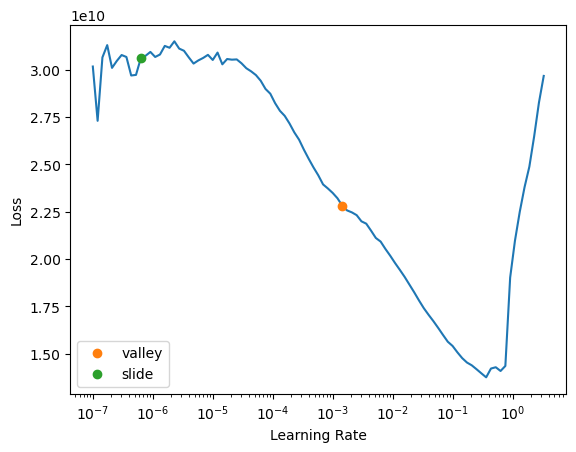

In [32]:
dls = fastai.TabularDataLoaders.from_df(df,procs=[fastai.Normalize],cont_names=["floor", "floor_area_sqm", "lease_commence_date", "date", "lat","long"],y_names=["resale_price"])
#dls.show_batch()
def MSE(yhat,y):
  return torch.mean(torch.square(yhat-y))
def RMSE(yhat,y):
  return torch.sqrt(MSE(yhat,y))
learn = fastai.tabular_learner(dls,y_range=(df.resale_price.min()*0.95, df.resale_price.max()*1.05),loss_func=MSE,metrics=RMSE)
learn.lr_find(suggest_funcs=(fastai.valley,fastai.slide))


In [42]:
learn = fastai.tabular_learner(
  dls,y_range=(df.resale_price.min()*0.95, df.resale_price.max()*1.05),
  loss_func=MSE,metrics=RMSE,
  cbs=[fastai.SaveModelCallback(),fastai.EarlyStoppingCallback(patience=5)]
)
learn.fit_one_cycle(100,5e-2)
learn.validate()


Better model found at epoch 0 with valid_loss value: 32147.888671875.


(#2) [1038592320.0,32147.888671875]

In [43]:
# predict prices on map
row = df.drop(['resale_price'], axis=1).iloc[0].copy()
cats = ['floor', 'floor_area_sqm', 'lease_commence_date', 'date']
for cat in cats:
  row[cat] = df[cat].median()
latMin, latMax = df.lat.min(),df.lat.max()
latLeft = latMin - (latMax-latMin)/10
latRight = latMax + (latMax-latMin)/10
longMin, longMax = df.long.min(),df.long.max()
longLeft = longMin - (longMax-longMin)/10
longRight = longMax + (longMax-longMin)/10
n1 = 5*25
n2 = 4*25
longs = np.linspace(longLeft, longRight, n1)
lats = np.linspace(latLeft, latRight, n2)
prices = np.ndarray((n2,n1))
for i,lat in enumerate(lats):
  if i%10==0: print(f"{i} of {n2}") 
  row['lat'] = lat
  for j,long in enumerate(longs):
    row['long'] = long
    with learn.no_bar(), learn.no_logging():
      _, yPred, _ = learn.predict(row)
      prices[i][j] = yPred.item()
print('done!')

0 of 100
10 of 100
20 of 100
30 of 100
40 of 100
50 of 100
60 of 100
70 of 100
80 of 100
90 of 100
done!


In [44]:
import http.client, urllib.parse
import json

mrts = ["Pioneer MRT", "Boon Lay MRT", "Lakeside MRT"]
longLats = load_pkl()

responses = []
for mrt in mrts:
	conn = http.client.HTTPConnection('api.positionstack.com')
	params = urllib.parse.urlencode({
		'access_key': key,
		'query': mrt[:-4] + ' Station',
		'region': 'Singapore',
		'limit': 1,
	})
	conn.request('GET', '/v1/forward?{}'.format(params))
	res = conn.getresponse()
	data = res.read()
	dataList = json.loads(data.decode('utf-8'))['data']
	if (len(dataList)==0): 
		print(f"check {add}. No data returned")
		count += 1
		errors.append(add)
		continue
	first_response = dataList[0]
	responses.append(first_response)
	if (first_response['confidence'] > 0.9) and (first_response['country']=='Singapore'):
		longLats[f"{mrt}"] = (first_response['longitude'], first_response['latitude'])
		print(f"{first_response['label']}, confidence {first_response['confidence']}")
	else:
		print(f"check {mrt}. {first_response['label']}. confidence of {first_response['confidence']}")

dump_pkl(longLats)


longLats loaded. 6164
Pioneer Station, Singapore, confidence 1
Opposite Boon Lay Station, Singapore, confidence 1
Lakeside Station, Singapore, confidence 1
pickle dumped. 6167


In [18]:
longLats['Upper Changi MRT']

(103.96138, 1.341393)

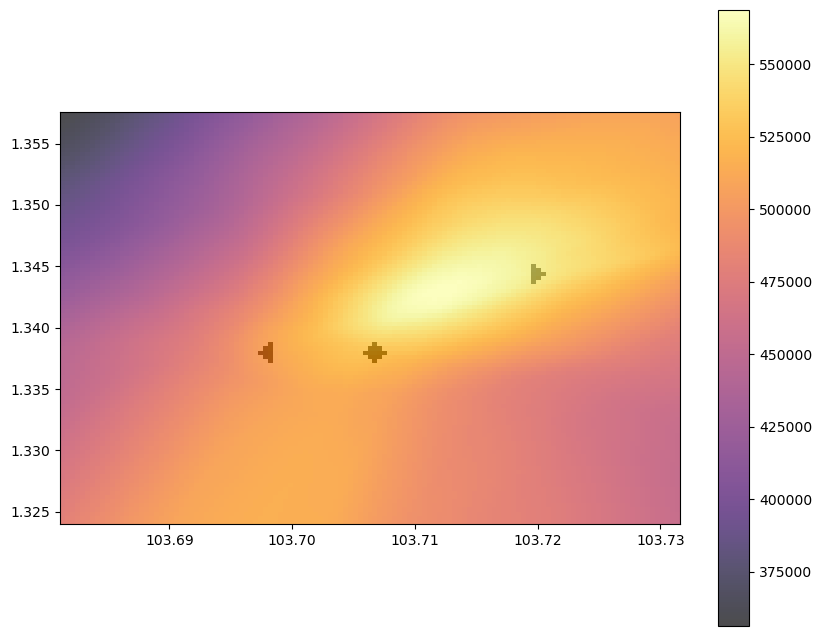

In [45]:
def min_coords(long,lat):
  return (np.abs((longs-long)).argmin(), np.abs(lats-lat).argmin())
def map_left(i,j):
  mrt_map[j-2][i+1]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j+1][i]=1
  mrt_map[j+1][i+1]=1
  mrt_map[j+2][i+1]=1
def map_sq(i,j):
  mrt_map[j-1][i-1]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j+1][i]=1
  mrt_map[j+1][i+1]=1
  mrt_map[j+1][i-1]=1
def map_right(i,j):
  mrt_map[j-2][i-1]=1
  mrt_map[j-1][i-1]=1
  mrt_map[j-1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j+1][i]=1
  mrt_map[j+1][i-1]=1
  mrt_map[j+2][i-1]=1
def map_up(i,j):
  mrt_map[j+1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j-1][i-2]=1
  mrt_map[j-1][i-1]=1
  mrt_map[j-1][i+2]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i]=1
def map_down(i,j):
  mrt_map[j-1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j+1][i-2]=1
  mrt_map[j+1][i-1]=1
  mrt_map[j+1][i+2]=1
  mrt_map[j+1][i+1]=1
  mrt_map[j+1][i]=1
def map_star(i,j):
  mrt_map[j+1][i]=1
  mrt_map[j+1][i-1]=1
  mrt_map[j+1][i+1]=1
  mrt_map[j-1][i]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i-1]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j][i-2]=1
  mrt_map[j][i+2]=1
  mrt_map[j+2][i]=1
  mrt_map[j-2][i]=1
mrt_map = np.zeros((n2,n1))

map_left(*min_coords(*longLats[mrts[0]]))
map_star(*min_coords(*longLats[mrts[1]]))
map_right(*min_coords(*longLats[mrts[2]]))
#map_down(*min_coords(*longLats[mrts[1]]))
#map_left(*min_coords(*longLats[mrts[2]]))
#map_right(*min_coords(*longLats[mrts[3]]))
#map_right(*min_coords(*longLats[mrts[4]]))

fig,ax=plt.subplots()
#mrt
#color map
shw2 = ax.imshow(mrt_map, extent=[longLeft, longRight, latLeft, latRight], origin='lower',cmap='Greys',alpha=1.0)
shw = ax.imshow(prices, extent=[longLeft, longRight, latLeft, latRight], origin='lower',alpha=0.7, cmap='inferno')
bar = plt.colorbar(shw)
fig.set_figwidth(10)
fig.set_figheight(10/n1*n2)

plt.show()

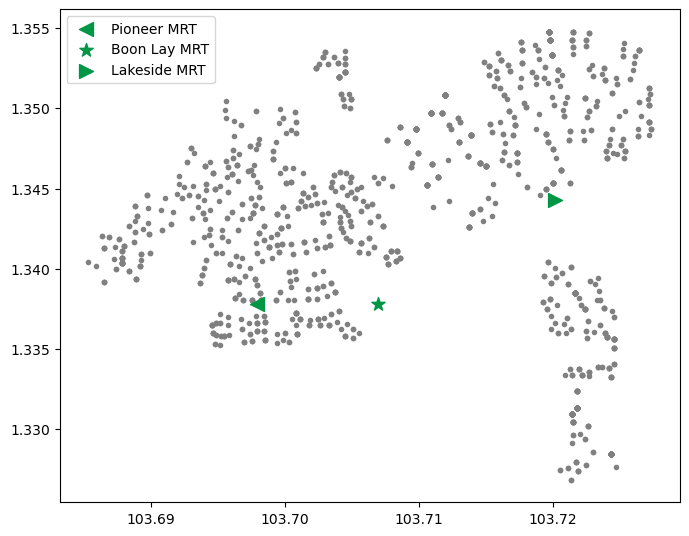

In [46]:
circle = "#FA9E0D"
ew = "#009645"
dt = "#005EC4"
red = '#d62728'
ne = '#9900AA'
markers = ["<", '*', ">", '>', '>', '^', '^']
colors = [ew,ew,ew]

fig,ax2=plt.subplots()
ax2.scatter(df.long,df.lat,marker='.',c='gray')
for i,mrt in enumerate(mrts):
  ax2.scatter([longLats[mrt][0]], [longLats[mrt][1]],marker=markers[i],c=colors[i],label=mrt,s=100)
ax2.legend(loc='upper left')
fig.set_figwidth(8)
fig.set_figheight(8/n1*n2)

plt.show()

for mrt in mrts:
  (i,j) = min_coords(*longLats[mrt])
